In [2]:
import os
from copy import deepcopy
from pathlib import Path
import random
import shutil

from tqdm import tqdm
from pprint import pprint
import pandas as pd
import numpy as np
import nibabel as nib

from bcblib.tools.general_utils import open_json, save_json
from lesseg_unet.utils import get_sex_int, get_age_int

%load_ext autoreload
%autoreload 2

In [32]:
from lesseg_unet.utils import get_perf_seg_dict, get_perf_seg_dict_from_folders
"""
First we need to create a dictionary with the segmentation files and the performance
"""
"""
INPUTS
"""
# Model trained with abnormals only (but with gen dice + focal loss)
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_analyses_abnormal_5fold_segmentation/'
# Model trained with both abnormals and ALL the controls (but with gen dice + focal loss)
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_analyses_controls_5fold_segmentation/'
# Model trained with both abnormals and the controls (but with gen dice + focal loss) without  biobank images
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_training_with_controls_gendice_focal_no_biobank/'

# Model trained with both abnormals and ALL the controls with dice + focal loss and a 0.1 weight on control loss
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div10_dicefocal/'
# Model trained with both abnormals and ALL the controls with dice + focal loss and a 0.001 weight on control loss
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal_4mm/'

# Simple UNet trained with abnormals only and without any augmentation
seg_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_training_no_augs_unet'
output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_abnormal_training_no_augs_unet_4mm/'

# /media/chrisfoulon/HDD2/final_training_set/abnormal_segmentation_dice_focal
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_segmentation_dice_focal'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_abnormal_segmentation_dice_focal_4mm/'


In [33]:


spm_seg_folder = Path(output_folder, 'spm_segmentation')
os.makedirs(output_folder, exist_ok=True)
os.makedirs(spm_seg_folder, exist_ok=True)

keys_struct = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict.json')

if Path(seg_folder, '__output_image_volumes.json').exists():
    seg_dict = get_perf_seg_dict(seg_folder, keys_struct=keys_struct, relative_output_paths=False)
else:
    print('process from folders')
    seg_dict = get_perf_seg_dict_from_folders(seg_folder, keys_struct=keys_struct, relative_output_paths=False)
# print first value of the dict
pprint({k: seg_dict[k] for k in random.sample(seg_dict.keys(), 1)})
# Then we need to copy the segmentation files to a separate folder for SPM ...
output_masks_folder = Path(output_folder, 'output_masks/')
output_labels_folder = Path(output_folder, 'output_labels/')
os.makedirs(output_masks_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)
spm_seg_dict = {}
main_key_to_process = 'label'
# main_key_to_process = 'segmentation'
for k in tqdm(seg_dict):
    shutil.copy(seg_dict[k]['segmentation'], output_masks_folder)
    shutil.copy(seg_dict[k]['label'], output_labels_folder)
    spm_seg_dict[k] = deepcopy(seg_dict[k])
    spm_seg_dict[k][main_key_to_process] = str(Path(spm_seg_folder, Path(seg_dict[k][main_key_to_process]).name.split('.gz')[0]))
    nib.save(nib.load(seg_dict[k][main_key_to_process]), spm_seg_dict[k][main_key_to_process])
print(len(seg_dict))
pprint({k: seg_dict[k] for k in random.sample(seg_dict.keys(), 1)})

save_json(Path(seg_folder, 'perf_seg_dict.json'), seg_dict)
save_json(Path(seg_folder, 'spm_perf_seg_dict.json'), spm_seg_dict)

process from folders


100%|██████████| 712/712 [00:30<00:00, 23.04it/s]
/tmp/ipykernel_16870/868534614.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  pprint({k: seg_dict[k] for k in random.sample(seg_dict.keys(), 1)})


{'1.2.840.846310145.12.1.1.60018303_20180417123407_201__pref__': {'Unnamed: 0': 661,
                                                                  'b1000': '/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_images/non_linear_co-rigid_rigid_geomean_denoise_1.2.840.846310145.12.1.1.60018303_20180417123407_201__pref___bval1000.nii.gz',
                                                                  'core_filename': 'non_linear_co-rigid_rigid_geomean_denoise_1.2.840.846310145.12.1.1.60018303_20180417123407_201__pref___bval1000_v4066v',
                                                                  'dice_metric': 0.9288119077682496,
                                                                  'distance': 1.0,
                                                                  'label': '/media/chrisfoulon/HDD2/final_training_set/abnormal_training_no_augs_unet/fold_4/val_images/R_Prefrontal/label_non_linear_co-rigid_rigid_geomean_denoise_1.2.840.846310145.12.1.1.60018303

100%|██████████| 3563/3563 [04:28<00:00, 13.27it/s]
/tmp/ipykernel_16870/868534614.py:29: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  pprint({k: seg_dict[k] for k in random.sample(seg_dict.keys(), 1)})


3563
{'ep2d_diff_3scan_trace_p2_aa_20130110141242_7__pref__': {'Unnamed: 0': 572,
                                                          'b1000': '/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_images/non_linear_co-rigid_rigid_geomean_denoise_ep2d_diff_3scan_trace_p2_aa_20130110141242_7__pref___bval1000.nii.gz',
                                                          'core_filename': 'non_linear_co-rigid_rigid_geomean_denoise_ep2d_diff_3scan_trace_p2_aa_20130110141242_7__pref___bval1000_v20v',
                                                          'dice_metric': 0.9230769276618958,
                                                          'distance': 1.0,
                                                          'label': '/media/chrisfoulon/HDD2/final_training_set/abnormal_training_no_augs_unet/fold_4/val_images/L_Posterior_borderzone/label_non_linear_co-rigid_rigid_geomean_denoise_ep2d_diff_3scan_trace_p2_aa_20130110141242_7__pref___bval1000_v20v_572.nii.gz',
    

In [34]:
"""
Then we need to create a dataframe with the performance metrics
"""
columns=[main_key_to_process, 'dice_metric', 'distance', 'volume', 'lesion_cluster', 'PatientAge', 'PatientSex']
b1000_info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict.json')


# dict_for_df = {}
# for k in seg_dict:
#     for col in columns:
#         if col in seg_dict:
#             dict_for_df[k][col] = seg_dict[k][col]
#         else:
#             dict_for_df[k][col] = b1000_info_dict[k][col]
#
# pprint({k: dict_for_df[k] for k in random.sample(dict_for_df.keys(), 1)})
# new_df = pd.DataFrame.from_records(dict_for_df).T
# new_df.to_csv(Path(seg_folder, 'segmentation_perf_df.csv'), columns=columns)

# create a function to do that
def get_df_from_dict(seg_dict, columns):
    dict_for_df = {}
    for k in seg_dict:
        dict_for_df[k] = {}
        for col in columns:
            if col in seg_dict[k]:
                if col == 'PatientAge':
                    dict_for_df[k][col] = get_age_int(seg_dict[k][col])
                elif col == 'PatientSex':
                    dict_for_df[k][col] = get_sex_int(seg_dict[k][col])
                else:
                    dict_for_df[k][col] = seg_dict[k][col]
            elif col == 'lesion_cluster':
                dict_for_df[k][col] = Path(seg_dict[k][main_key_to_process]).parent.name
            else:
                if col == 'PatientAge':
                    dict_for_df[k][col] = get_age_int(b1000_info_dict[k][col])
                elif col == 'PatientSex':
                    dict_for_df[k][col] = get_sex_int(b1000_info_dict[k][col])
                else:
                    dict_for_df[k][col] = b1000_info_dict[k][col]
    new_df = pd.DataFrame.from_records(dict_for_df).T
    return new_df

# use it on seg_dict and spm_seg_dict
new_df = get_df_from_dict(seg_dict, columns)
new_df.to_csv(Path(output_folder, 'segmentation_perf_df.csv'), columns=columns)
new_df = get_df_from_dict(spm_seg_dict, columns)
new_df.to_csv(Path(output_folder, 'spm_segmentation_perf_df.csv'), columns=columns)

In [35]:
"""
Then we need to zscore the columns
"""
zcores_columns = ['dice_metric', 'distance', 'volume', 'PatientAge', 'PatientSex']
for col in zcores_columns:
    # pd.to_numeric(new_df[col])
    new_df[col] = new_df[col].infer_objects()
#     print(col)
#     print(new_df[col].dtype)
#     new_df[col] = new_df[col].apply(stats.zscore)
normalized_df = new_df[zcores_columns]
normalized_df=(normalized_df-normalized_df.mean())/normalized_df.std()
normalized_df=(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
new_df[zcores_columns] = normalized_df[zcores_columns]
new_df.to_csv(Path(seg_folder, 'segmentation_perf_df_zscored.csv'), columns=columns)

In [36]:
from nilearn.image import smooth_img
# smooth all the images from the segmentation dict with key 'segmentation' and save them in '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation_masks_smoothed_8'
smooth_out_folder = output_folder + 'masks_smoothed_4'
os.makedirs(smooth_out_folder, exist_ok=True)
spm_smoothed_seg_dict = {}
for k in tqdm(spm_seg_dict):
    smoothed_img = smooth_img(spm_seg_dict[k][main_key_to_process], 4)
    spm_smoothed_seg_dict[k] = deepcopy(spm_seg_dict[k])
    spm_smoothed_seg_dict[k][main_key_to_process] = str(Path(smooth_out_folder, Path(spm_seg_dict[k][main_key_to_process]).name))
    nib.save(smoothed_img, spm_smoothed_seg_dict[k][main_key_to_process])



100%|██████████| 3563/3563 [03:07<00:00, 19.02it/s]


In [37]:
new_df = get_df_from_dict(spm_smoothed_seg_dict, columns)
new_df.to_csv(Path(output_folder, 'spm_smoothed_segmentation_perf_df.csv'), columns=columns)
# STOP HERE FOR SIMPLE MODEL/DICE SPM COMPARISON

In [25]:
# Now, we use the spm_smoothed_segmentation_perf_df.csv from each directory in model_perf_dir_list and create a new multi_model_dice_comparison_df
model_perf_dir_list = [
    '/media/chrisfoulon/HDD2/final_training_set/perf_labels_analyses_abnormal_5fold_segmentation',
    # '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div10_dicefocal',
    '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal'
]

model_perf_df_list = [
    pd.read_csv(Path(model_perf_dir, 'spm_smoothed_segmentation_perf_df.csv'), index_col=0)
    for model_perf_dir in model_perf_dir_list
]

multi_model_dice_comparison_df = pd.DataFrame()
# add the 'label' column of the first df to multi_model_dice_comparison_df
multi_model_dice_comparison_df['label'] = model_perf_df_list[0]['label']
# add the 'dice_metric' column of each df to multi_model_dice_comparison_df (with folder name as column name + '_dice_metric')
for i, model_perf_df in enumerate(model_perf_df_list):
    multi_model_dice_comparison_df[model_perf_dir_list[i].split('/')[-1] + '_dice_metric'] = model_perf_df['dice_metric']

b1000_ground_truths_label_seize_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')

# keys in b1000_ground_truths_label_seize_dict are the same as in multi_model_dice_comparison_df[0] first column. Match them and add the label size to multi_model_dice_comparison_df
multi_model_dice_comparison_df['label_size'] = [b1000_ground_truths_label_seize_dict[k]['label_size']  for k in multi_model_dice_comparison_df.index]

# save the multi_model_dice_comparison_df
multi_model_dice_comparison_df.to_csv('/media/chrisfoulon/HDD2/final_training_set/multi_model_dice_comparison_df.csv', columns=multi_model_dice_comparison_df.columns)

In [ ]:
from lesseg_unet.utils import weight_lesion_dataset

biobank_ctr_folder_name = 'perf_analyses_controls_5fold_segmentation'
no_biobank_ctr_folder_name = 'perf_training_with_controls_gendice_focal_no_biobank'
ctr_folder_name = no_biobank_ctr_folder_name

abnormal_df_path = Path('/media/chrisfoulon/HDD2/final_training_set/perf_analyses_abnormal_5fold_segmentation/', 'spm_smoothed_segmentation_perf_df.csv')
controls_df_path = Path(f'/media/chrisfoulon/HDD2/final_training_set/{ctr_folder_name}/', 'spm_smoothed_segmentation_perf_df.csv')

abnormal_weighted_output_folder = Path('/media/chrisfoulon/HDD2/final_training_set/perf_analyses_abnormal_5fold_segmentation/', 'dice_weighted_smoothed_lesions')
controls_weighted_output_folder = Path(f'/media/chrisfoulon/HDD2/final_training_set/{ctr_folder_name}/', 'dice_weighted_smoothed_lesions')

# weight the images of the abnormal dataset
abnormal_weighted_dict, abnormal_weighted_df = weight_lesion_dataset(abnormal_df_path, 'segmentation', 'dice_metric', abnormal_weighted_output_folder, 'Unnamed: 0')
# save the weighted dataframe
abnormal_weighted_df.to_csv(Path('/media/chrisfoulon/HDD2/final_training_set/perf_analyses_abnormal_5fold_segmentation/', 'dice_weighted_smoothed_lesions_segmentation_perf_df.csv'), columns=abnormal_weighted_df.columns)

# weight the images of the controls dataset
controls_weighted_dict, controls_weighted_df = weight_lesion_dataset(controls_df_path, 'segmentation', 'dice_metric', controls_weighted_output_folder, 'Unnamed: 0')
# save the weighted dataframe
controls_weighted_df.to_csv(Path(f'/media/chrisfoulon/HDD2/final_training_set/{ctr_folder_name}/', 'dice_weighted_smoothed_lesions_segmentation_perf_df.csv'), columns=controls_weighted_df.columns)


# for each row in abnormal_weighted_df, find the corresponding row in controls_weighted_df using 'Unnamed: 0'
# then compute the substraction of the nifti images in 'weighted_path' and save the result in a new folder
dice_substraction_folder = Path('/media/chrisfoulon/HDD2/final_training_set/', 'dice_subtraction_smoothed_lesions_no_biobank')
os.makedirs(dice_substraction_folder, exist_ok=True)
for row in tqdm(abnormal_weighted_df.iterrows()):
    key = row[1]['Unnamed: 0']
    abnormal_path = row[1]['weighted_path']
    abnormal_nifti = nib.load(abnormal_path)
    abnormal_data = abnormal_nifti.get_fdata()
    control_path = controls_weighted_df[controls_weighted_df['Unnamed: 0'] == key]['weighted_path'].values[0]
    control_nifti = nib.load(control_path)
    control_data = control_nifti.get_fdata()
    dice_substraction = abnormal_data - control_data
    dice_substraction_nifti = nib.Nifti1Image(dice_substraction, affine=abnormal_nifti.affine)
    nib.save(dice_substraction_nifti, Path(dice_substraction_folder, Path(abnormal_path).name.replace('.nii.gz', '.nii')))

In [4]:
# Now, we want to compute the mean dice_metric between a list of perf_seg_dict and save the {key: 'mean_dice_metric': value, 'mean_distance': value_average_distance} in a new dict
perf_seg_dict_list = [
    open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json')
]

mean_dice_dict = {}
for k in perf_seg_dict_list[0]:
    mean_dice_dict[k] = {}
    mean_dice_dict[k]['mean_dice_metric'] = np.mean([d[k]['dice_metric'] for d in perf_seg_dict_list])
    mean_dice_dict[k]['mean_distance'] = np.mean([d[k]['distance'] for d in perf_seg_dict_list])
    
# sort the dict by mean_dice_metric (ascending)
mean_dice_dict = {k: v for k, v in sorted(mean_dice_dict.items(), key=lambda item: item[1]['mean_dice_metric'])}
    
save_json(Path('/media/chrisfoulon/HDD2/final_training_set/', 'mean_dice_dict.json'), mean_dice_dict)

In [4]:
mean_dice_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/mean_dice_dict.json')
# print all values with mean_distance = 0
for k in mean_dice_dict:
    if mean_dice_dict[k]['mean_distance'] == 0:
        print(k)
        print(mean_dice_dict[k]['mean_dice_metric'])
        print(mean_dice_dict[k]['mean_distance'])

DTI_P6d_noniso_SENSE_20150731120209_301__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20180301104234_201__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20160618125529_201__pref__
0.0
0.0
ep2d_diff_3scan_trace_20070324110557_9__pref__
0.0
0.0
ep2d_diff_3scan_ipat_20141022143252_6__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20160722100258_201__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20160711083742_201__pref__
0.0
0.0
DTI_P6d_noniso_20190112135713_201__pref__
0.9755767226219177
0.0
1.3.46.670589.11.38075.5.0.1820.2018040815523831006_20180408155238_201__pref__
0.9875420689582824
0.0
DTI_P6d_noniso_20190315163801_201__pref__
0.987842321395874
0.0
1.2.840.846310145.12.1.1.60286619_20180831163807_201__pref__
0.9879709959030152
0.0
1.2.840.846310145.12.1.1.60317294_20180915142847_201__pref__
0.9880144834518433
0.0
1.2.840.846310145.12.1.1.60692052_20190315163801_201__pref__
0.9884455084800721
0.0
DTI_P6d_noniso_SENSE_20180718155058_201__pref__
0.9889434337615967
0.0
DTI_P6d_noniso_SENSE_20151214153600_301__pref__
0.9917016

In [12]:
from bcblib.tools.visualisation import display_img

perf_seg_dict_list = [
    open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json')
]
# For every image with a mean_dice_metric <= 0, display perf_seg_dict_list[-2][k]['b1000'] with display_img
for k in mean_dice_dict:
    if 0.01 < mean_dice_dict[k]['mean_dice_metric'] <= 0.2 and 0.5 < mean_dice_dict[k]['mean_distance'] < 3:
        print(k)
        print(mean_dice_dict[k]['mean_dice_metric'])
        print(mean_dice_dict[k]['mean_distance'])
        # display_img(perf_seg_dict_list[-2][k]['b1000'], perf_seg_dict_list[-2][k]['label'], display='fsleyes')
        display_img(perf_seg_dict_list[-2][k]['b1000'], perf_seg_dict_list[-2][k]['label'], perf_seg_dict_list[-2][k]['segmentation'], display='fsleyes')

DTI_P6d_noniso_SENSE_20151112143421_301__pref__
0.04636363759636878
2.9771296018981586
Fsleyes command: "fsleyes /media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_images/non_linear_co-rigid_rigid_geomean_denoise_DTI_P6d_noniso_SENSE_20151112143421_301__pref___bval1000.nii.gz /media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/fold_2/val_images/empty_prediction/label_non_linear_co-rigid_rigid_geomean_denoise_DTI_P6d_noniso_SENSE_20151112143421_301__pref___bval1000_v0v_71.nii.gz -cm red -a 40 /media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/fold_2/val_images/empty_prediction/output_non_linear_co-rigid_rigid_geomean_denoise_DTI_P6d_noniso_SENSE_20151112143421_301__pref___bval1000_v0v_71.nii.gz -cm green -a 40"
Error/Warning during fsleyes execution
exit status: 0
stderr: given by the platformdirs library.  To remove this warning and
see the appropriate new directories, set the environment variable
`JUPYTER_PLATFORM_DIRS=1`

KeyboardInterrupt: 

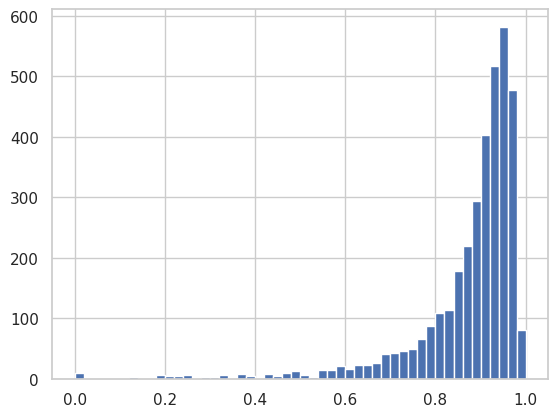

In [12]:
# plot the distribution of the mean_dice_metric
import matplotlib.pyplot as plt
plt.hist([mean_dice_dict[k]['mean_dice_metric'] for k in mean_dice_dict], bins=50)
plt.show()

In [ ]:
perf_seg_dict_list = [
    open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json')
]

perf_seg_dict_parent_folder_name_list = [
    'abnormal_5fold_segmentation',
    'controls_trained_5fold_segmentation',
    'training_with_controls_gendice_focal_no_biobank_segmentation',
    'control_training_wf_div10_dicefocal',
    'control_training_wf_div1000_dicefocal'
]

# display the distribution of the dice_metric for each dataset related to the volume of the lesion and compute the correlation between the two on each plot 
from scipy.stats import pearsonr
# make plots taller and larger
plt.rcParams['figure.figsize'] = [20, 15]
for i, perf_seg_dict in enumerate(perf_seg_dict_list):
    # print(perf_seg_dict_parent_folder_name_list[i])
    plt.scatter([perf_seg_dict[k]['volume'] for k in perf_seg_dict], [perf_seg_dict[k]['dice_metric'] for k in perf_seg_dict])
    corr = pearsonr([perf_seg_dict[k]['volume'] for k in perf_seg_dict], [perf_seg_dict[k]['dice_metric'] for k in perf_seg_dict])
    plt.title(f'{perf_seg_dict_parent_folder_name_list[i]} / corr: {corr[0]:.2f}')
    plt.show()
    print(corr)

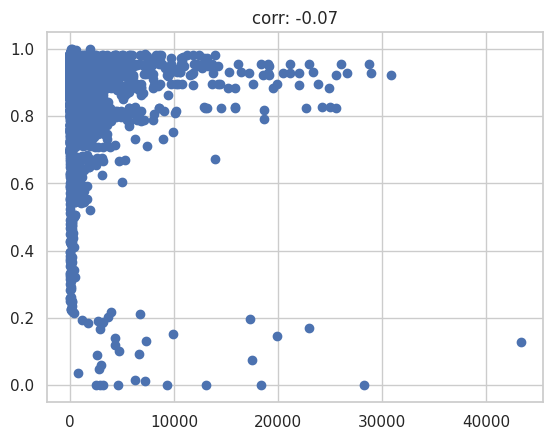

PearsonRResult(statistic=-0.07214794158358694, pvalue=1.627528355889108e-05)


In [18]:
# do the same but for the label size from b1000_label_dict and the mean_dice_metric from the mean_dice_dict
b1000_label_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')
plt.scatter([b1000_label_dict[k]['label_size'] for k in b1000_label_dict], [mean_dice_dict[k]['mean_dice_metric'] for k in mean_dice_dict])
corr = pearsonr([b1000_label_dict[k]['label_size'] for k in b1000_label_dict], [mean_dice_dict[k]['mean_dice_metric'] for k in mean_dice_dict])
plt.title(f'corr: {corr[0]:.2f}')
plt.show()
print(corr)


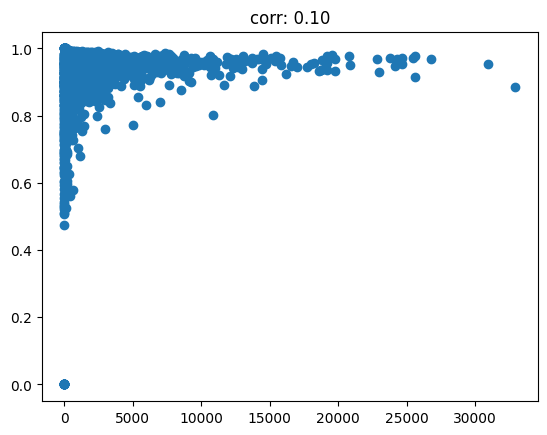

In [22]:
# plot lesion volume function of distance_ratio and display the correlation
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
# '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict_with_distance_ratio.json'
perf_seg_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict_with_distance_ratio.json')
plt.scatter([perf_seg_dict[k]['volume'] for k in perf_seg_dict], [perf_seg_dict[k]['dice_dist_ratio'] for k in perf_seg_dict])
corr = pearsonr([perf_seg_dict[k]['volume'] for k in perf_seg_dict], [perf_seg_dict[k]['dice_dist_ratio'] for k in perf_seg_dict])
plt.title(f'corr: {corr[0]:.2f}')
plt.show()

In [42]:
from lesseg_unet.loss_and_metric import distance_ratio_volume

def perf_seg_dict_add_distance_ratio(perf_seg_dict_path, output_path):
    perf_seg_dict = open_json(perf_seg_dict_path)
    for k in tqdm(perf_seg_dict):
        # add the distance_ratio to the perf_seg_dict and then add the average of dice_metric and distance_ratio to the dice_dist_ratio 
        perf_seg_dict[k]['distance_ratio'] = distance_ratio_nifti(perf_seg_dict[k]['label'], perf_seg_dict[k]['segmentation'])
        perf_seg_dict[k]['dice_dist_ratio'] = (perf_seg_dict[k]['dice_metric'] + perf_seg_dict[k]['distance_ratio']) / 2
    # sort the dict by dice_dist_ratio (ascending)
    perf_seg_dict = {k: v for k, v in sorted(perf_seg_dict.items(), key=lambda item: item[1]['dice_dist_ratio'])}
    # save the perf_seg_dict
    save_json(output_path, perf_seg_dict)

perf_seg_dict_list = [
    # '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json',
    # '/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json',
    # '/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json',
    # '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json',
    # '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json',
    '/media/chrisfoulon/HDD2/final_training_set/abnormal_segmentation_dice_focal/perf_seg_dict.json'
]

# run perf_seg_dict_add_distance_ratio on each perf_seg_dict
for perf_seg_dict in perf_seg_dict_list:
    perf_seg_dict_add_distance_ratio(perf_seg_dict, perf_seg_dict.replace('.json', '_with_distance_ratio.json'))

  4%|▍         | 154/3563 [00:04<01:21, 41.85it/s]/home/chrisfoulon/miniconda3/lib/python3.10/site-packages/monai/metrics/hausdorff_distance.py:193: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/chrisfoulon/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 3563/3563 [01:30<00:00, 39.40it/s]


In [43]:
# list paths of _with_distance_ratio perf_seg_dict
perf_seg_dict_with_distance_ratio_list = [
    '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict_with_distance_ratio.json',
    '/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict_with_distance_ratio.json',
    '/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict_with_distance_ratio.json',
    '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict_with_distance_ratio.json',
    '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict_with_distance_ratio.json'
    '/media/chrisfoulon/HDD2/final_training_set/abnormal_segmentation_dice_focal/perf_seg_dict_with_distance_ratio.json'
]

# load each of them and print the name of the file and the mean of all the dice_metric, distance, distance_ratio and dice_dist_ratio and volume (all the keys in the dict)
# for perf_seg_dict in perf_seg_dict_with_distance_ratio_list:
#     print(Path(perf_seg_dict).name)
#     perf_seg_dict = open_json(perf_seg_dict)
#     print(np.mean([perf_seg_dict[k]['dice_metric'] for k in perf_seg_dict]))
#     print(np.mean([perf_seg_dict[k]['distance'] for k in perf_seg_dict]))
#     print(np.mean([perf_seg_dict[k]['distance_ratio'] for k in perf_seg_dict]))
#     print(np.mean([perf_seg_dict[k]['dice_dist_ratio'] for k in perf_seg_dict]))
#     print(np.mean([perf_seg_dict[k]['volume'] for k in perf_seg_dict]))
#     print()
    
# instead the values should be displayed next to each other (one line per perf_seg_dict)

for perf_seg_dict in perf_seg_dict_with_distance_ratio_list:
    print(Path(perf_seg_dict).parent.name)
    perf_seg_dict = open_json(perf_seg_dict)
    print(np.mean([perf_seg_dict[k]['dice_metric'] for k in perf_seg_dict]), end=' ')
    print(np.mean([perf_seg_dict[k]['distance'] for k in perf_seg_dict]), end=' ')
    print(np.mean([perf_seg_dict[k]['distance_ratio'] for k in perf_seg_dict]), end=' ')
    print(np.mean([perf_seg_dict[k]['dice_dist_ratio'] for k in perf_seg_dict]), end=' ')
    print(np.mean([perf_seg_dict[k]['volume'] for k in perf_seg_dict]), end=' ')
    print()
    

abnormal_5fold_segmentation
0.8767417732227846 3.0536868960945602 0.9798508924589319 0.9282963328408582 1287.0550098231827 
controls_trained_5fold_segmentation
0.8653619464540683 3.1977899177640716 0.9751108413831678 0.9202363939186182 1289.110861633455 
training_with_controls_gendice_focal_no_biobank_segmentation
0.8640696352581412 3.1693777748993397 0.976810409699441 0.9204400224787913 1266.066797642436 
control_training_wf_div10_dicefocal
0.8700511560548194 3.0248708811432015 0.9786163353959315 0.9243337457253755 1286.9980353634578 
abnormal_segmentation_dice_focal


NotADirectoryError: [Errno 20] Not a directory: '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict_with_distance_ratio.json/media/chrisfoulon/HDD2/final_training_set/abnormal_segmentation_dice_focal/perf_seg_dict_with_distance_ratio.json'

In [32]:
from lesseg_unet.visualisation_utils import perf_dataset_overlap_from_json

# 
# nib.save(abn_overlap, '/media/chrisfoulon/HDD2/final_training_set/test_abnormal_gen_dice_focal_training/fold_0_abnormal_validation/val_perf_overlap.nii.gz')

# Compute the weighted overlap between the segmentation and the label for each image in the perf_seg_dict of the perf_seg_dict_with_distance_ratio_list
for perf_seg_dict_path in perf_seg_dict_with_distance_ratio_list:
    print(Path(perf_seg_dict_path).parent.name)
    perf_seg_dict = open_json(perf_seg_dict_path)
    overlap = perf_dataset_overlap_from_json(perf_seg_dict, 'segmentation', perf_key='dice_dist_ratio', non_zero_only=True)
    nib.save(overlap, Path(Path(perf_seg_dict_path).parent, 'dice_dist_ratio_overlap.nii.gz'))




abnormal_5fold_segmentation


100%|██████████| 3563/3563 [01:58<00:00, 30.02it/s]


controls_trained_5fold_segmentation


100%|██████████| 3563/3563 [01:11<00:00, 49.81it/s]


training_with_controls_gendice_focal_no_biobank_segmentation


100%|██████████| 3563/3563 [01:12<00:00, 49.46it/s]


control_training_wf_div10_dicefocal


100%|██████████| 3563/3563 [02:12<00:00, 26.95it/s]


control_training_wf_div1000_dicefocal


100%|██████████| 3563/3563 [01:56<00:00, 30.55it/s]


In [58]:
# load /media/chrisfoulon/DATA1/a_imagepool_mr/ischaemic_stroke_seg_latest/unified_info_manual_check_dict_PatientAge_fixed.json
info_dict = open_json('/media/chrisfoulon/DATA1/a_imagepool_mr/ischaemic_stroke_seg_latest/unified_info_manual_check_dict_PatientAge_fixed.json')
print(len(info_dict))
seg_folder = '/media/chrisfoulon/DATA1/a_imagepool_mr/ischaemic_stroke_seg_latest/segmentation_new_control_trained_model'
input_list = [str(p) for p in Path(seg_folder).glob('**/input*.nii.gz')]
print(len(input_list))
output_list = [str(p) for p in Path(seg_folder).glob('**/output*.nii.gz')]
print(len(output_list))
for k in tqdm(info_dict):
    # try to match each info_dict[k]['b1000'] (replace 'input_' and 'output_' by '' and take .split('_v')[0]) 
    # name_to_match = info_dict[k]['b1000'].replace('input_', '').replace('output_', '').split('_v')[0].split('__pref__')[0]
    name_to_match = k
    input_match = [i for i in input_list if name_to_match in Path(i).name]
    output_match = [o for o in output_list if name_to_match in Path(o).name]
    # if len of either is 0 or > 1, print the name_to_match and the len of the matches and exit
    if len(input_match) != 1 or len(output_match) != 1:
        """
        v = Path(info_dict[k]['b1000']).name.replace('input_', '').replace('output_', '').split('_v')[0].split('__pref__')[0]
        print(v)
        # is v in any name of input_list
        print([vv for vv in input_list if v in Path(vv).name])
        """
        name_to_match = Path(info_dict[k]['b1000']).name.replace('input_', '').replace('output_', '').split('_v')[0].split('__pref__')[0]
        input_match = [i for i in input_list if name_to_match in Path(i).name]
        output_match = [o for o in output_list if name_to_match in Path(o).name]
        if len(input_match) != 1 or len(output_match) != 1:
            print(k)
            print(name_to_match)
            print(len(input_match))
            print(len(output_match))
            print()
            # exit()
        else:
            # else, add the input_match and output_match to info_dict[k]
            info_dict[k]['b1000'] = str(input_match[0])
            info_dict[k]['segmentation'] = str(output_match[0])
    else:
        # else, add the input_match and output_match to info_dict[k]
        info_dict[k]['b1000'] = str(input_match[0])
        info_dict[k]['segmentation'] = str(output_match[0])
# save the info_dict
save_json('/media/chrisfoulon/DATA1/a_imagepool_mr/ischaemic_stroke_seg_latest/unified_info_manual_check_dict_segmentation_new_control_trained_model.json', info_dict)

6346
6346
6346


100%|██████████| 6346/6346 [06:19<00:00, 16.73it/s]


In [ ]:
from lesseg_unet.utils import create_perf_df_from_folds_root

info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')

div1000_folder = '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal'
abnormal_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_segmentation_dice_focal'
unet_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_training_no_augs_unet'

div1000_minus_abnormal_output_folder = '/media/chrisfoulon/HDD2/final_training_set/div1000_minus_abnormal'
os.makedirs(div1000_minus_abnormal_output_folder, exist_ok=True)
div1000_minus_unet_output_folder = '/media/chrisfoulon/HDD2/final_training_set/div1000_minus_unet'
os.makedirs(div1000_minus_unet_output_folder, exist_ok=True)

div1000_perf_df = create_perf_df_from_folds_root(div1000_folder, info_dict)
# save the div1000_perf_df in div1000_folder
div1000_perf_df.to_csv(Path(div1000_folder, 'complete_perf_df.csv'), columns=div1000_perf_df.columns)
abnormal_perf_df = create_perf_df_from_folds_root(abnormal_folder, info_dict)
# save the abnormal_perf_df in abnormal_folder
abnormal_perf_df.to_csv(Path(abnormal_folder, 'complete_perf_df.csv'), columns=abnormal_perf_df.columns)
unet_perf_df = create_perf_df_from_folds_root(unet_folder, info_dict)
# save the unet_perf_df in unet_folder
unet_perf_df.to_csv(Path(unet_folder, 'complete_perf_df.csv'), columns=unet_perf_df.columns)

# in each result folder 

In [130]:
print(len(unet_perf_df))

3563


In [58]:
from nilearn.image import smooth_img
info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')

# apply a 4 voxels smoothing to the labels in info_dict[k]['label'] and save the result in a new folder '/media/chrisfoulon/HDD2/final_training_set/cleaned_labels_smoothed_4mm'
# create the folder
cleaned_labels_smoothed_4mm_folder = '/media/chrisfoulon/HDD2/final_training_set/cleaned_labels_smoothed_4mm'
os.makedirs(cleaned_labels_smoothed_4mm_folder, exist_ok=True)
# for each key in info_dict, load the image at info_dict[k]['label'] and apply a 4 voxels smoothing to it
smoothed_labels_info_dict = {}
for k in tqdm(info_dict):
    smoothed_labels_info_dict[k] = info_dict[k]
    label_nifti = nib.load(info_dict[k]['label'])
    smoothed_label_nifti = smooth_img(label_nifti, 4)
    # save the smoothed_label_nifti in cleaned_labels_smoothed_4mm_folder
    nib.save(smoothed_label_nifti, Path(cleaned_labels_smoothed_4mm_folder, f'{k}.nii'))
    # add the path to the smoothed_label_nifti to smoothed_labels_info_dict[k]
    smoothed_labels_info_dict[k]['smoothed_label'] = str(Path(cleaned_labels_smoothed_4mm_folder, f'{k}.nii'))
# save the smoothed_labels_info_dict
save_json(Path(cleaned_labels_smoothed_4mm_folder, 'cleaned_abnormal_b1000_info_dict_label_size_smoothed_labels.json'), smoothed_labels_info_dict)


100%|██████████| 3563/3563 [06:08<00:00,  9.66it/s]


In [59]:
# compute subtraction of 4mm smoothed labels weighted with dice of div1000 and abnormal and save them in div1000_minus_abnormal_output_folder
smoothed_labels_info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')
div1000_minus_abnormal_output_folder = '/media/chrisfoulon/HDD2/final_training_set/div1000_minus_abnormal_swinunetr'
os.makedirs(div1000_minus_abnormal_output_folder, exist_ok=True)
# first we import the spreadsheet listing the smoothed labels (e.g. /media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal_4mm/spm_smoothed_segmentation_perf_df.csv)
div1000_perf_df = pd.read_csv('/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal_4mm/spm_smoothed_segmentation_perf_df.csv', index_col=0)
abnormal_perf_df = pd.read_csv('/media/chrisfoulon/HDD2/final_training_set/perf_labels_abnormal_segmentation_dice_focal_4mm/spm_smoothed_segmentation_perf_df.csv', index_col=0) 
subtraction_df = pd.DataFrame(columns=['smoothed_label', 'label_volume', 'subtraction_dice_metric'])
for key, row in tqdm(div1000_perf_df.iterrows()):
    # find the corresponding row in abnormal_perf_df
    abnormal_row = abnormal_perf_df.loc[key]
    # save the weighted_label_nifti in abnormal_weighted_output_folder
    # nib.save(subtraction_weighted_label_nifti, Path(div1000_minus_abnormal_output_folder_labels, f'{key}.nii'))
    # fill up the info in subtraction_df (indices are the keys)
    subtraction_df.loc[key] = [info_dict[key]['smoothed_label'], info_dict[key]['label_size'],
                               row['dice_metric'] - abnormal_row['dice_metric']]

    
# save subtraction_df in div1000_minus_abnormal_output_folder
subtraction_df.to_csv(Path(div1000_minus_abnormal_output_folder, 'subtraction_df.csv'), columns=subtraction_df.columns)


3563it [00:02, 1224.91it/s]


In [60]:
# same but with div1000 minus unet
smoothed_labels_info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')
div1000_minus_unet_output_folder = '/media/chrisfoulon/HDD2/final_training_set/div1000_minus_unet'
os.makedirs(div1000_minus_unet_output_folder, exist_ok=True)
# first we import the spreadsheet listing the smoothed labels (e.g. /media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal_4mm/spm_smoothed_segmentation_perf_df.csv)
div1000_perf_df = pd.read_csv('/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal_4mm/spm_smoothed_segmentation_perf_df.csv', index_col=0)
unet_perf_df = pd.read_csv('/media/chrisfoulon/HDD2/final_training_set/perf_labels_abnormal_training_no_augs_unet_4mm/spm_smoothed_segmentation_perf_df.csv', index_col=0)
subtraction_df = pd.DataFrame(columns=['smoothed_label', 'label_volume', 'subtraction_dice_metric'])

for key, row in tqdm(div1000_perf_df.iterrows()):
    # find the corresponding row in abnormal_perf_df
    unet_row = unet_perf_df.loc[key]
    # save the weighted_label_nifti in abnormal_weighted_output_folder
    # nib.save(subtraction_weighted_label_nifti, Path(div1000_minus_abnormal_output_folder_labels, f'{key}.nii'))
    # fill up the info in subtraction_df (indices are the keys)
    subtraction_df.loc[key] = [info_dict[key]['smoothed_label'], info_dict[key]['label_size'],
                               row['dice_metric'] - unet_row['dice_metric']]
# save subtraction_df in div1000_minus_abnormal_output_folder
subtraction_df.to_csv(Path(div1000_minus_unet_output_folder, 'subtraction_df.csv'), columns=subtraction_df.columns)

3563it [00:03, 1177.32it/s]


In [61]:
div1000_minus_unet_subtraction_df = pd.read_csv('/media/chrisfoulon/HDD2/final_training_set/div1000_minus_unet/subtraction_df.csv', index_col=0)
# print the mean and std of the subtraction_dice_metric
print(np.mean(div1000_minus_unet_subtraction_df['subtraction_dice_metric']))
print(np.std(div1000_minus_unet_subtraction_df['subtraction_dice_metric']))

0.05750330210705981
0.10830266293910887


In [194]:
from lesseg_unet.utils import create_perf_df_from_folds_root
fold_root_folder = '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal'
info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')
div1000_perf_df = create_perf_df_from_folds_root(fold_root_folder, info_dict)
# save the div1000_perf_df in div1000_folder
div1000_perf_df.to_csv(Path(fold_root_folder, 'complete_perf_df.csv'), columns=div1000_perf_df.columns)
# print(len(div1000_perf_df))
# perf_dict = div1000_perf_df.to_dict(orient='index')
# print(len(perf_dict))
# # save the perf_dict
# if not len(perf_dict) > 3000:
#     save_json(Path(fold_root_folder, 'complete_perf_dict.json'), perf_dict)

Found 5 val_perf_individual_measures.csv files
Found 3563 output_*.nii files
Found 3563 rows in total in the val_perf_individual_measures.csv files
Unique labels in keys_struct: 3563
Unique keys in keys_struct: 3563


3563 output files, 3563 keys: : 3563it [01:23, 42.77it/s]


Found 3563 keys
Found 3563 output files
Unique keys matched: 3563
Unique output files matched: 3563
Unique keys in val_perf_df: 3563
Unique labels in val_perf_df: 3563
Unique segmentations in val_perf_df: 3563
Unique core_filenames in val_perf_df: 3563


In [203]:
print(div1000_perf_df.columns)
print(f'Unique keys in val_perf_df: {len(np.unique(div1000_perf_df["key"].to_list()))}')
print(f'Unique keys in val_perf_df: {len((div1000_perf_df["key"].to_list()))}')
print(len(info_dict))
print(len(div1000_perf_df['key'].unique()))
print(len(div1000_perf_df['label'].unique()))


Index(['Unnamed: 0', 'core_filename', 'dice_metric', 'volume', 'distance',
       'key', 'label', 'segmentation', 'distance_ratio', 'volume_ratio'],
      dtype='object')
Unique keys in val_perf_df: 3563
Unique keys in val_perf_df: 3563
3563
3563
3563


In [217]:
# print first row of df
# print(div1000_perf_df.iloc[0])
# convert div1000_perf_df to a dict with the column 'key' as keys
perf_dict = {}
print(len(div1000_perf_df))
# print number of unique 'key' values
print(len(div1000_perf_df['key'].unique()))
for ind, row in tqdm(div1000_perf_df.iterrows()):
    k = row['key']
    perf_dict[k] = row.to_dict()
print(len(perf_dict))
# print first key and value


3563
3563


3563it [00:00, 15281.29it/s]

3563


In [222]:
print(len(perf_dict))
# print first key and value
print(list(perf_dict.keys())[0])
print(perf_dict[list(perf_dict.keys())[0]])

# same with info_dict
print(len(info_dict))
# print first key and value
print(list(info_dict.keys())[0])
print(info_dict[list(info_dict.keys())[0]])

3563
wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01
{'Unnamed: 0': 0, 'core_filename': 'wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01_v31121v', 'dice_metric': 0.9149065017700196, 'volume': 31121, 'distance': 2.2360680103302, 'key': 'wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01', 'label': '/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_labels/label_wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01.nii.gz', 'segmentation': '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/fold_0/val_images/R_Anterior_MCA/output_wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01_v31121v_0.nii.gz', 'distance_ratio': 0.9879050150445222, 'volume_ratio': 1.1016673156571914}
3563
wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01
{'b1000': '/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_images/wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01.nii.gz', 'PatientID': '91145295', 'StudyDate': '20070

In [223]:
from lesseg_unet.utils import add_cluster_to_dict

# for k in tqdm(perf_dict):
#     del perf_dict[k]['lesion_cluster']
# Add a lesion_cluster attribute in the perf_dict (is is the parent name directory of the segmentation)
perf_dict = add_cluster_to_dict(perf_dict)
for k in tqdm(perf_dict):
    perf_dict[k]['pref_lesion_cluster'] = str(Path(perf_dict[k]['segmentation']).parent.name)
# save the perf_dict
save_json(Path(fold_root_folder, 'complete_perf_dict.json'), perf_dict)

100%|██████████| 3563/3563 [00:00<00:00, 144019.29it/s]


In [218]:
# print first values 
print(list(perf_dict.values())[0])

{'Unnamed: 0': 0, 'core_filename': 'wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01_v31121v', 'dice_metric': 0.9149065017700196, 'volume': 31121, 'distance': 2.2360680103302, 'key': 'wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01', 'label': '/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_labels/label_wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01.nii.gz', 'segmentation': '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/fold_0/val_images/R_Anterior_MCA/output_wodctH25_b1000_clmp_b1000_s91145295-0003-00000-000001-01_v31121v_0.nii.gz', 'distance_ratio': 0.9879050150445222, 'volume_ratio': 1.1016673156571914}


['cleaned_abnormal_labels']


AttributeError: 'Axes' object has no attribute 'flatten'

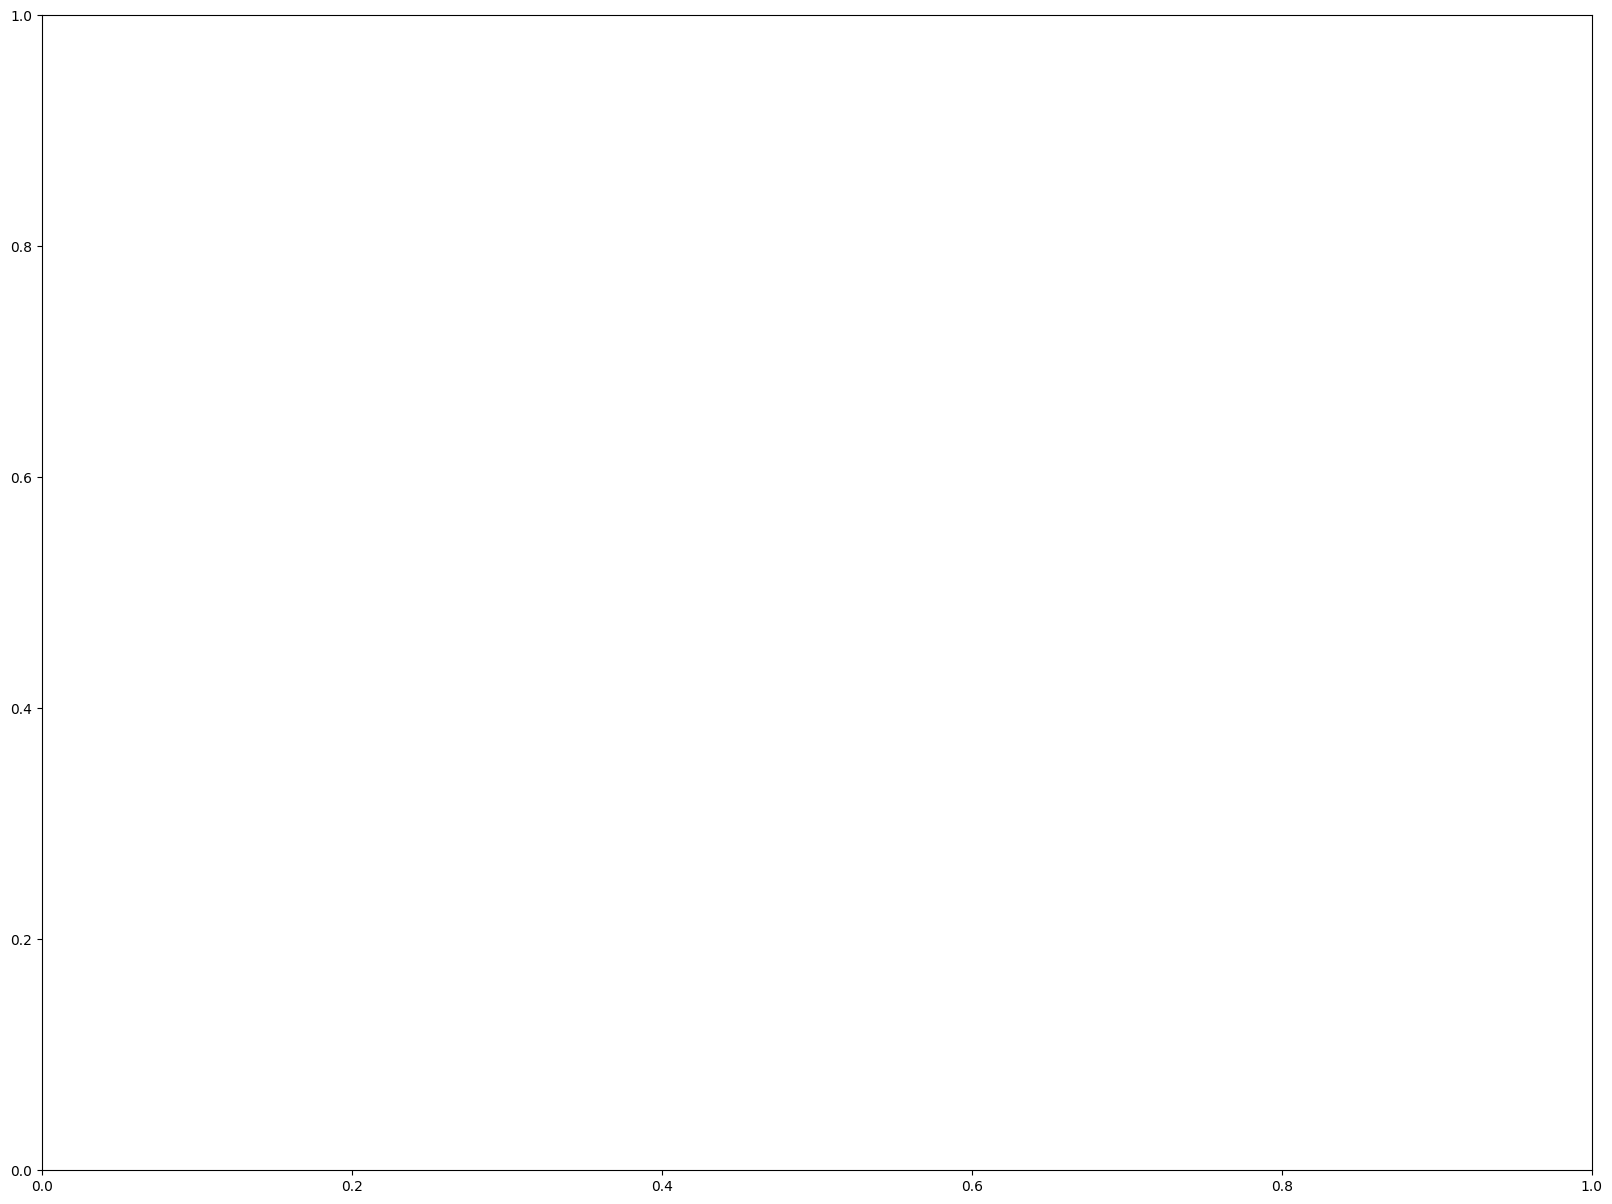

In [208]:
# Here, the goal is to use perf_dict to plot the distribution of the dice_metric for each lesion_cluster (one violinplot per lesion_cluster) and to compute the correlation between the lesion_cluster and the dice_metric and display all the plots in one figure (save it as a png in the fold_root_folder)
# Some cluster names start with L_ or R_, but we only care about what is after L_ or R_ when it is in the name
# We can use the following code to get the list of lesion_clusters
lesion_cluster_list = list(set([perf_dict[k]['lesion_cluster'].split('L_')[-1].split('R_')[-1] for k in perf_dict]))
print(lesion_cluster_list)

# For each lesion_cluster, create a list of dice_metric values
dice_metric_list = []
for lesion_cluster in lesion_cluster_list:
    dice_metric_list.append([perf_dict[k]['dice_metric'] for k in perf_dict if lesion_cluster in perf_dict[k]['lesion_cluster']])
    
# Then, plot the distribution of the dice_metric for each lesion_cluster (one violinplot per lesion_cluster) and compute the correlation between the lesion_cluster and the dice_metric and display all the plots in one figure (save it as a png in the fold_root_folder)
import seaborn as sns
import matplotlib.pyplot as plt
# import pearnonr
from scipy.stats import pearsonr
# plot up to 4 violinplots per row
# fig, axes = plt.subplots(len(lesion_cluster_list) // 4 + 1, 4)
# plot all the violinplots on one line with a shared y axis
fig, axes = plt.subplots(1, len(lesion_cluster_list), sharey=True)

# make plots taller and larger
plt.rcParams['figure.figsize'] = [20, 15]
# fix error: AttributeError: 'numpy.ndarray' object has no attribute 'fill_betweenx'
axes = axes.flatten()
# all plots y axis should be between 0 and 1
for ax in axes:
    ax.set_ylim(0, 1)
    
# x labels should be diagonal
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for ind, lesion_cluster in enumerate(lesion_cluster_list):
    sns.violinplot(ax=axes[ind], data=dice_metric_list[ind])
    
    
    
        
    

# plt.savefig(Path(fold_root_folder, 'lesion_cluster_dice_metric_correlation.png'))

plt.show()


# for ind, lesion_cluster in enumerate(lesion_cluster_list):
#         sns.violinplot(ax=axes[ind], data=metric_list[ind])
#         # title should be the lesion_cluster, number of images in the cluster and the mean metric
#         axes[ind].set_title(f'{lesion_cluster} / {len(metric_list[ind])} ')
#         # metric name : mean metric value should be the x label
#         axes[ind].set_xlabel(f'{metric_name} : {np.mean(metric_list[ind]):.2f}')
#         # remove the x scale 
#         axes[ind].set_xticks([])

In [224]:
# create a function that takes a perf_seg_dict, an output folder and a metric name (found in perf_dict) and creates the plots and saves them in the output folder
import seaborn as sns
import matplotlib.pyplot as plt


def plot_perf_violin_per_cluster(perf_seg_dict, output_folder, metric_name='dice_metric', y_val_range=(0, 1)):
    lesion_cluster_list = list(set([perf_seg_dict[k]['lesion_cluster'].split('L_')[-1].split('R_')[-1] for k in perf_seg_dict]))
    # For each lesion_cluster, create a list of metric values
    metric_list = []
    for lesion_cluster in lesion_cluster_list:
        metric_list.append([perf_seg_dict[k][metric_name] for k in perf_seg_dict if lesion_cluster in perf_seg_dict[k]['lesion_cluster']])
    # sort the cluster list and the metric list by the mean of the metric (decreasing)
    lesion_cluster_list, metric_list = zip(*sorted(zip(lesion_cluster_list, metric_list), key=lambda x: np.mean(x[1]), reverse=True))
    # Then, plot the distribution of the metric for each lesion_cluster (one violinplot per lesion_cluster) and compute the correlation between the lesion_cluster and the metric and display all the plots in one figure (save it as a png in the fold_root_folder)
    # fig, axes = plt.subplots(len(lesion_cluster_list) // 4 + 1, 4)
    fig, axes = plt.subplots(1, len(lesion_cluster_list), sharey=True)  
    # make plots taller and larger
    plt.rcParams['figure.figsize'] = [20, 15]
    # Add space between rows
    fig.subplots_adjust(hspace=0.5)
    # fix error: AttributeError: 'numpy.ndarray' object has no attribute 'fill_betweenx'
    axes = axes.flatten()
    # all plots y axis should be between 0 and 1
    # if y_val_range is not None:
    if y_val_range is not None:
        for ax in axes:
            ax.set_ylim(y_val_range)
    else:
        # compute the min and max of the metric_list
        min_metric = min([min(metric) for metric in metric_list])
        max_metric = max([max(metric) for metric in metric_list])
        for ax in axes:
            ax.set_ylim(min_metric, max_metric)
    # # if the number of lesion_cluster is not a multiple of 4, the last row of plots should be empty
    # if len(lesion_cluster_list) % 4 != 0:
    #     for ax in axes[-(4 - len(lesion_cluster_list) % 4):]:
    #         ax.axis('off')

    for ind, lesion_cluster in enumerate(lesion_cluster_list):
        sns.violinplot(ax=axes[ind], data=metric_list[ind])
        # corr = pearsonr([perf_dict[k]['volume'] for k in perf_dict if lesion_cluster in perf_dict[k]['lesion_cluster']], [perf_dict[k]['dice_metric'] for k in perf_dict if lesion_cluster in perf_dict[k]['lesion_cluster']])
        # title should be the lesion_cluster, number of images in the cluster and the mean metric
        # axes[ind].set_title(f'{lesion_cluster} / {len(metric_list[ind])} / {np.mean(metric_list[ind]):.2f}')
        # instead of title, the lesion_cluster, number of images in the cluster and the mean metric should be displayed on the x axis in diagonal
        axes[ind].set_xlabel(f'{lesion_cluster}', rotation=45, ha='right')
        # axes[ind].set_xlabel(f'{lesion_cluster} / {len(metric_list[ind])} / {np.mean(metric_list[ind]):.2f}', rotation=45, ha='right')
        
    plt.savefig(Path(output_folder, f'{metric_name}_lesion_cluster_correlation.png'))
    plt.show()
    
    

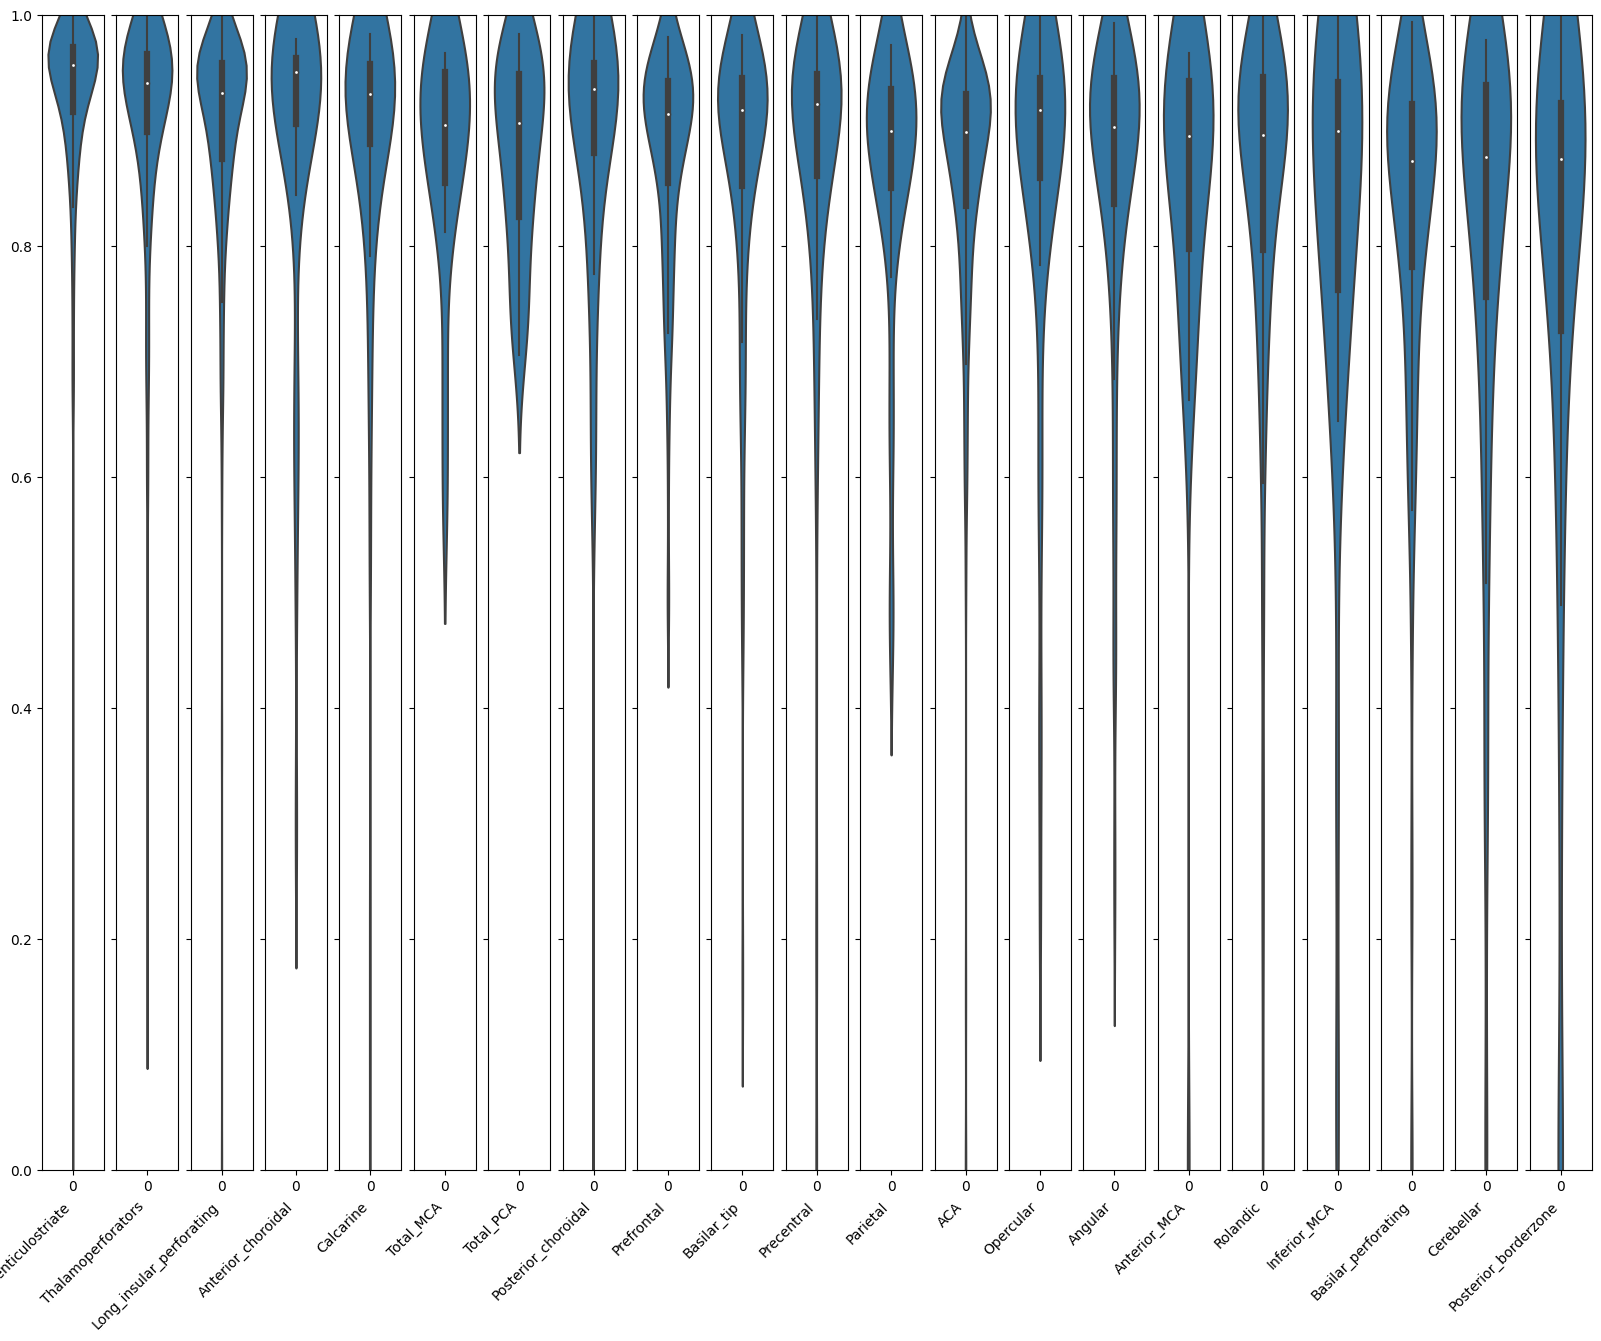

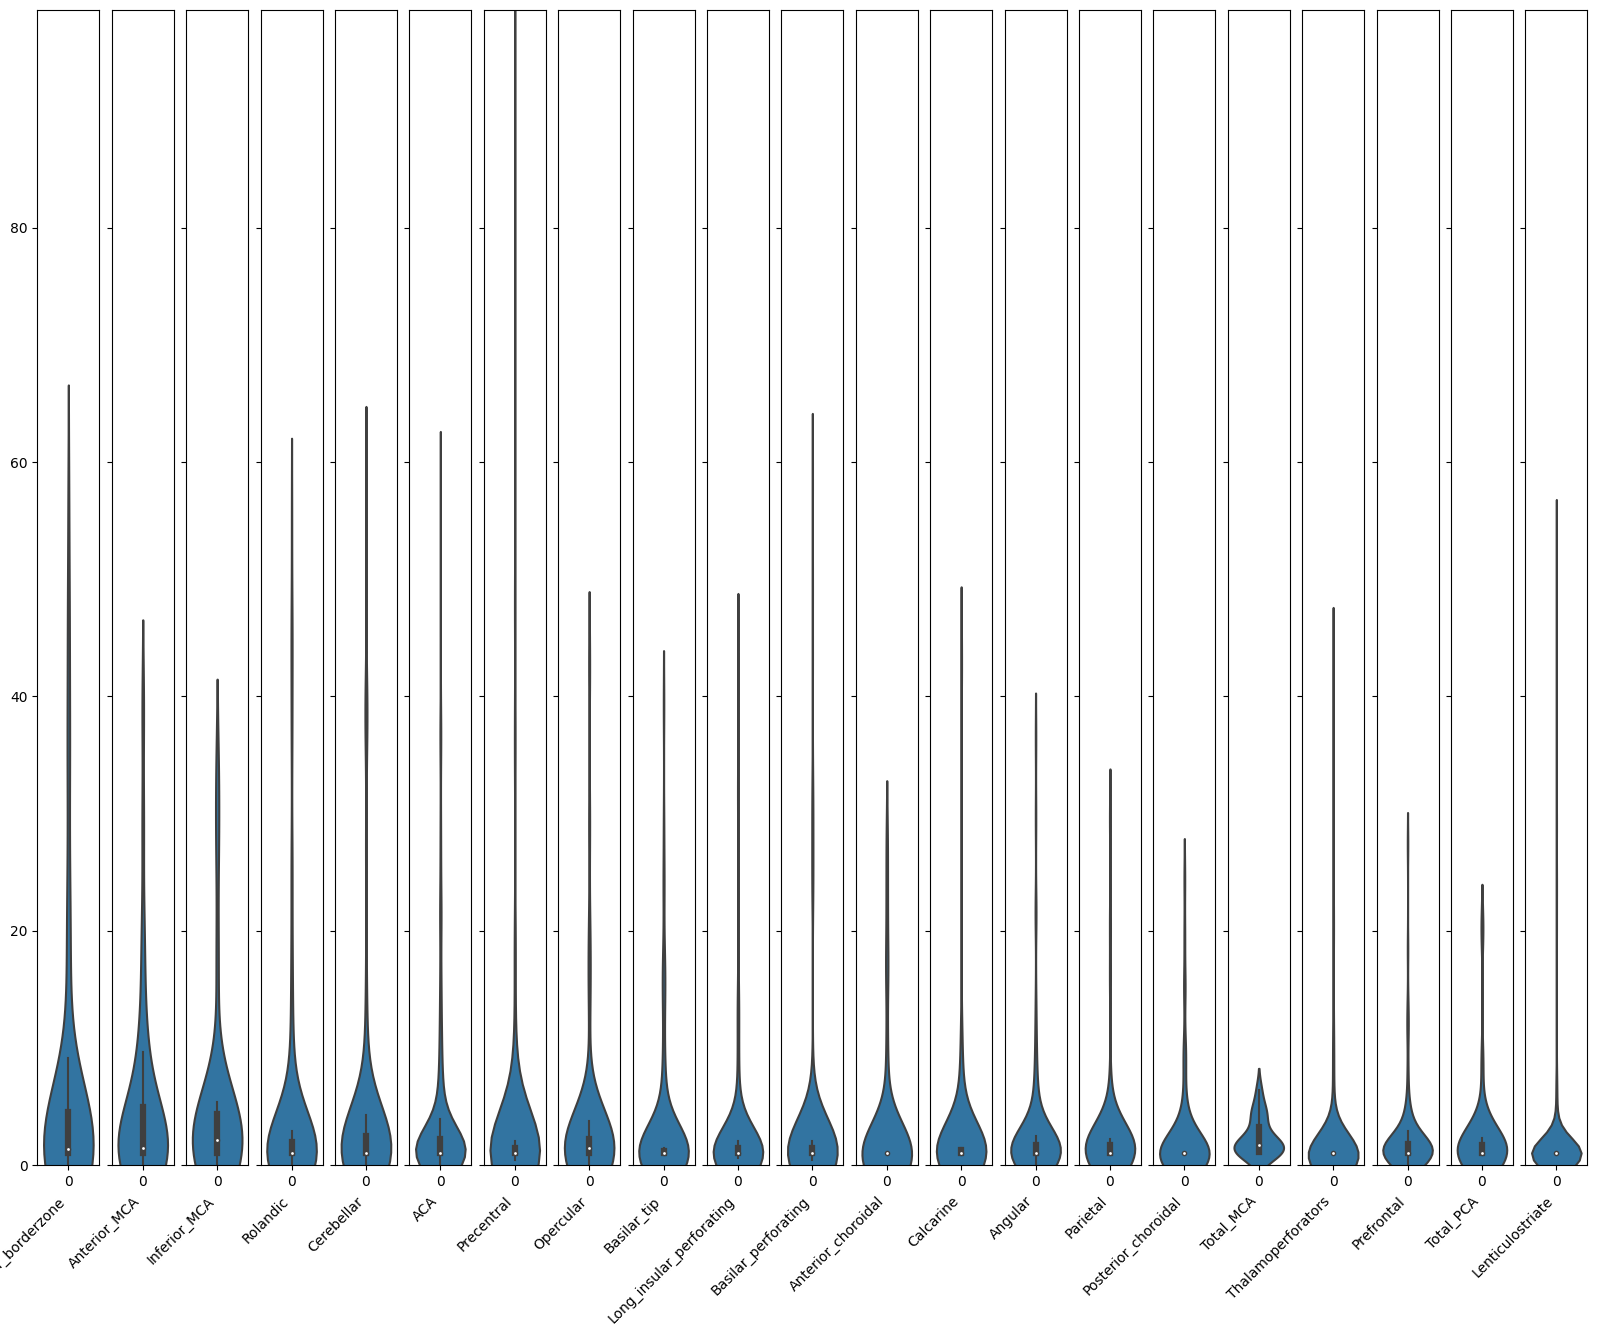

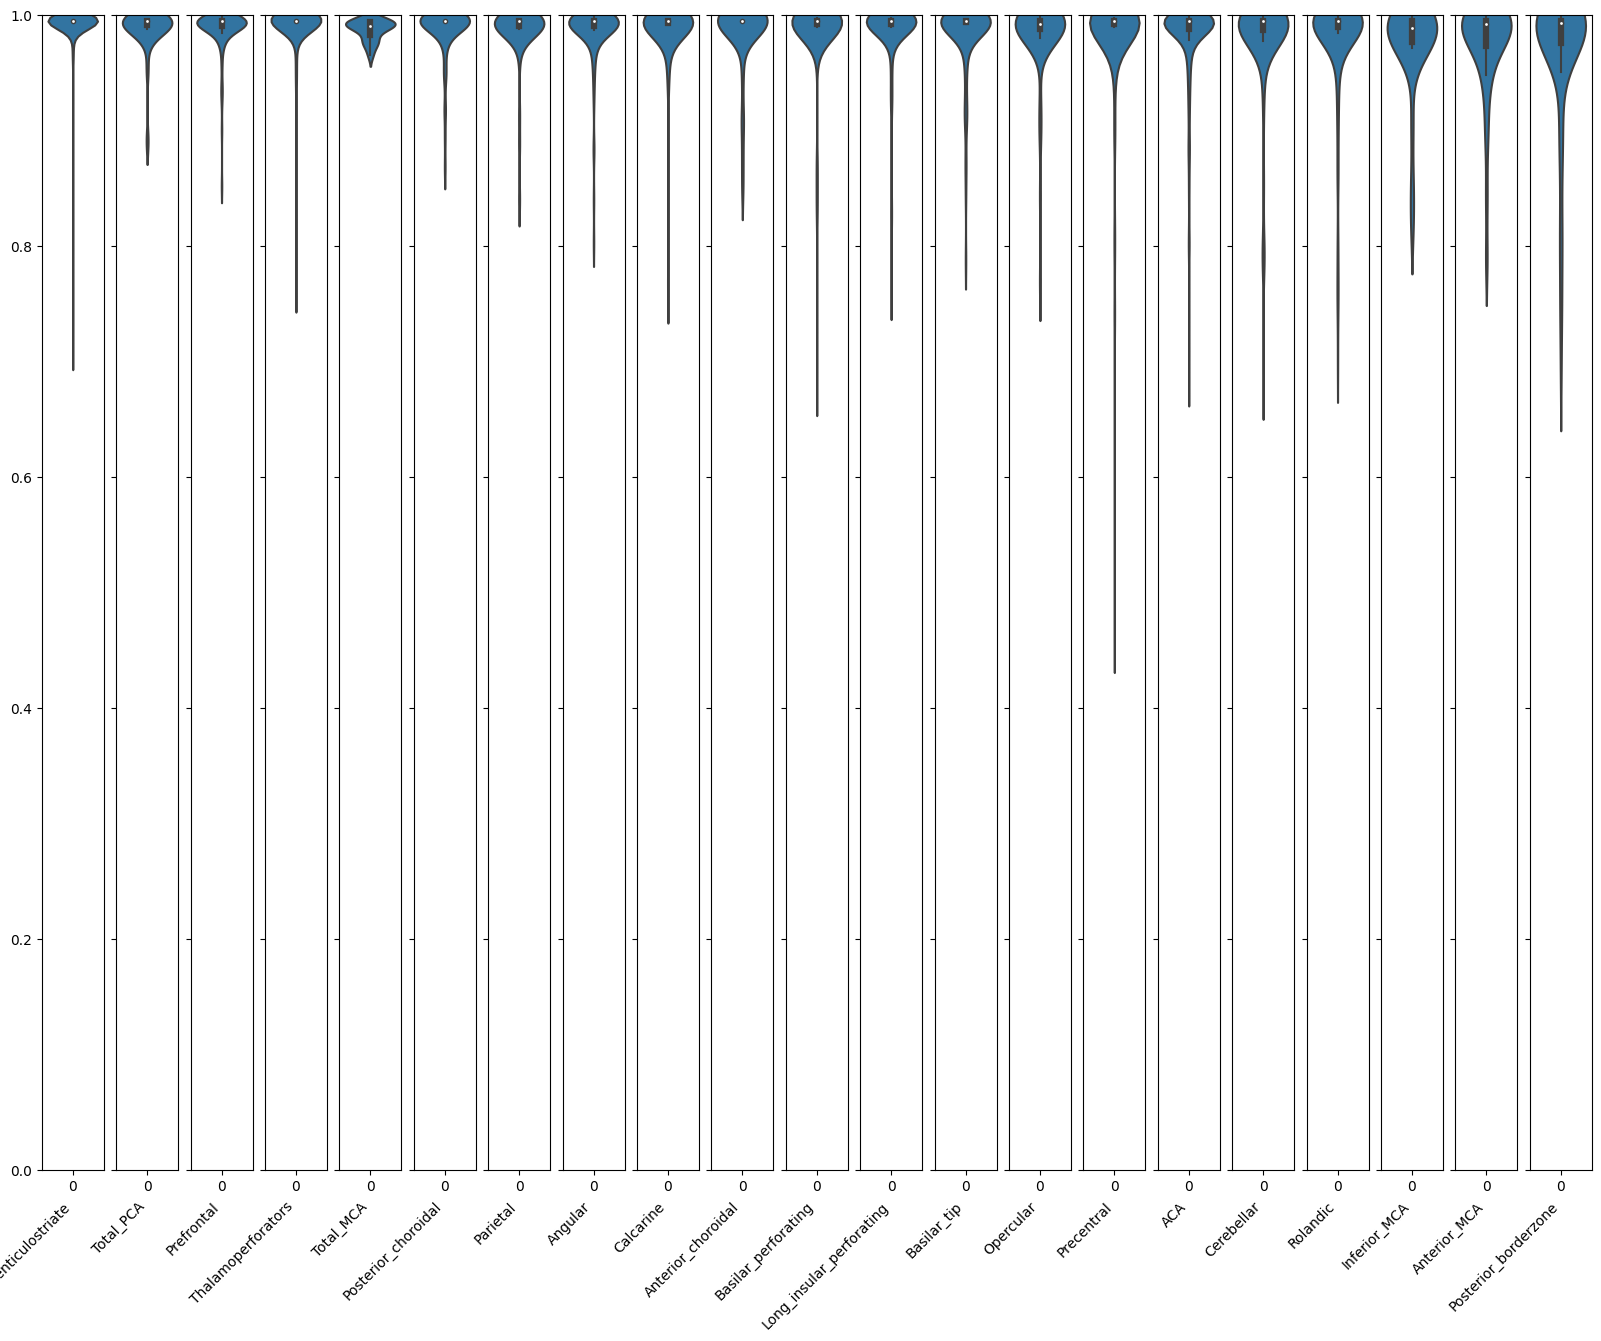

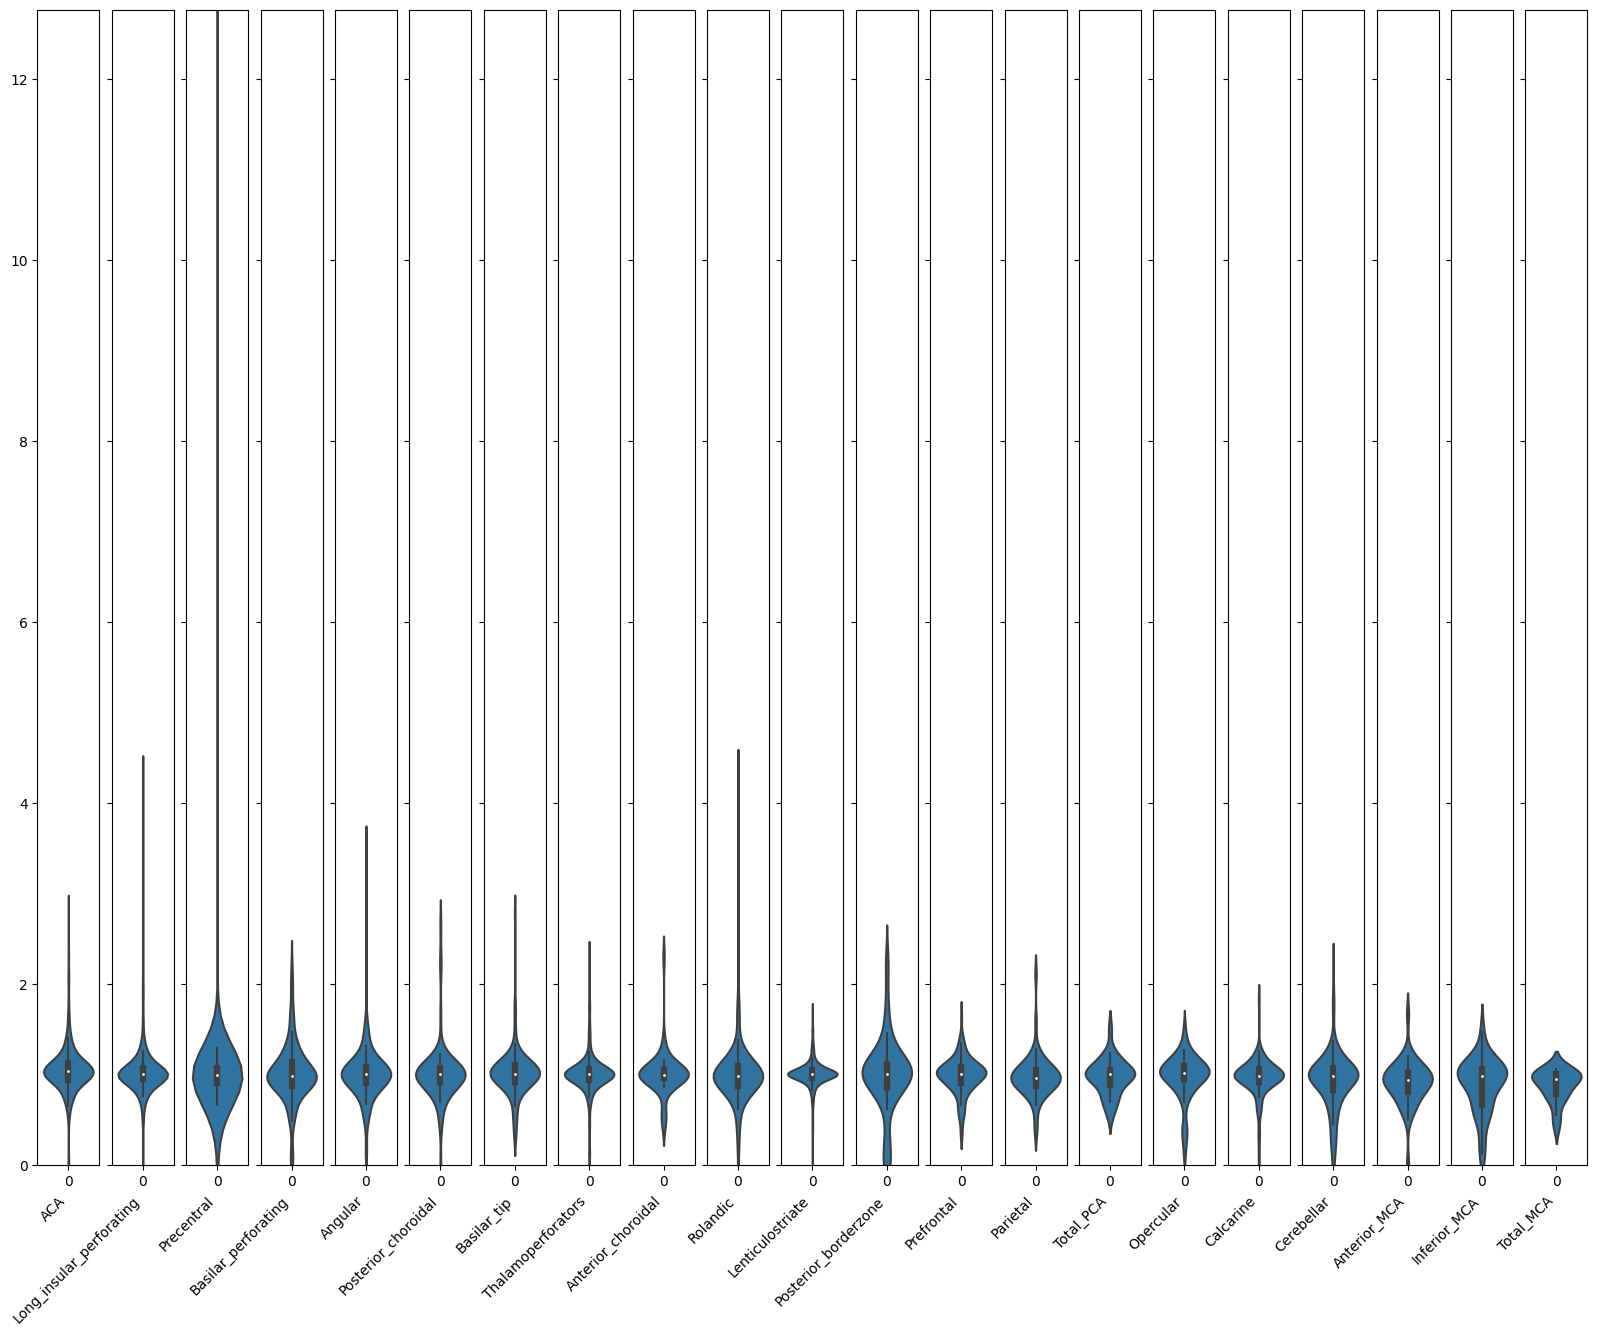

In [225]:
# use the function on the perf_dict for div1000 with dice_metric, distance and distance_ratio and volume_ratio
plot_perf_violin_per_cluster(perf_dict, fold_root_folder, metric_name='dice_metric')
plot_perf_violin_per_cluster(perf_dict, fold_root_folder, metric_name='distance', y_val_range=None)
plot_perf_violin_per_cluster(perf_dict, fold_root_folder, metric_name='distance_ratio')
plot_perf_violin_per_cluster(perf_dict, fold_root_folder, metric_name='volume_ratio', y_val_range=None)
